In [57]:
import os
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import shutil   # use to move PDF out of the directory
import datetime
from datetime import date, datetime, timedelta



from IPython.display import display, HTML    # make the screen bigger!
display(HTML(data=""" <style>    div#notebook-container    { width: 85%; }    div#menubar-container    
{ width: 85%; }    div#maintoolbar-container { width: 99%; } </style> """))     


pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib notebook

In [58]:
path_raw_data = (os.path.join("..", "..", "Raw_data/Stream_gauges/Messed_up_baros"))

data = pd.read_csv(os.path.join(path_raw_data, 'Baro2-060919.csv'))      # read each file     Baro2-060919.csv   and   Baro1-060919.csv

data = data.iloc[:,0:4]
data.columns = ['Date', 'Time', 'psi', 'temp']; float_cols = ['psi', 'temp']  # define columns for processing
data['Date and Time'] = data['Date'] + ' ' + data['Time']
del data['Date']; del data['Time'] 


# data cleaning
data['Date and Time'] = pd.to_datetime(data['Date and Time'])   # String date to real date
data['Date and Time'] = data['Date and Time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))  # make sure each entry is on a 15 min rounded interval: note rounds down to the last 15 min interval
for h in float_cols:                
    data[h]=data[h].astype(float)              # make sure all the data is in float form 

data_big = data.copy()

In [59]:
data = data_big

data['psi_step'] = data['psi'] - data['psi'].shift(1)
data['jump_type'] = np.nan
data['Correction_factor'] = np.nan


# set a threshold for what counts as a jump and record the next point after each jump
#### revise values later   #######
data.loc[data['psi_step'] > .04, 'jump_type'] = 'step_up'    
data.loc[data['psi_step'] < -.04, 'jump_type'] = 'step_down'

data['position'] = np.nan
pos = 'down'
cor_factor = 0

# Iterate over dataframe 
tempframe = pd.DataFrame()           # container for the rows as we add them on
for index, row in data.iterrows(): 
    tempframe = tempframe.append(row)
    
    if  row['jump_type'] == 'step_up':
        pos = "up"
        cor_factor = 0
        
    if  row['jump_type'] == 'step_down':
        pos = "down"
        cor_factor = -row['psi_step']
    
    tempframe['position'].iloc[-1] = pos
    tempframe['Correction_factor'].iloc[-1] = cor_factor
    
tempframe['corr_psi'] = tempframe['psi']  + tempframe['Correction_factor']

<IPython.core.display.Javascript object>


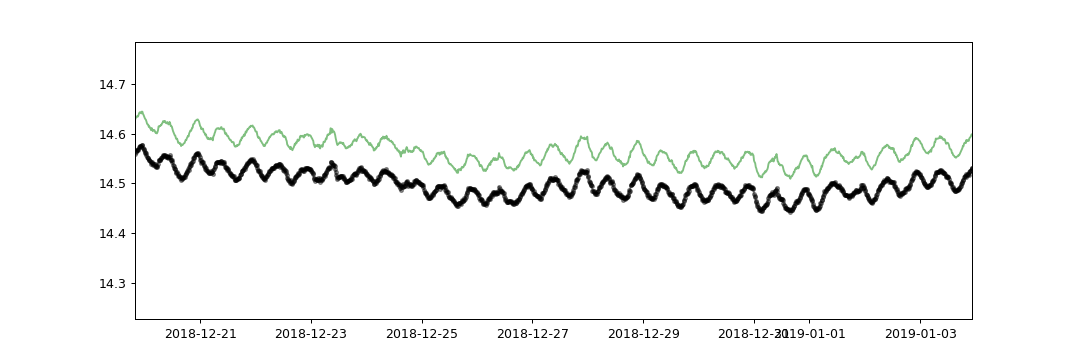

In [60]:
# Plot to see
fig = plt.figure(figsize=(12, 4))
ax1 = plt.axes()
plt.plot(data['Date and Time'], data['psi'], alpha = .4, marker='.', color='k')  # ploet each file in color

plt.plot(tempframe['Date and Time'], tempframe['corr_psi'], alpha = .5, marker='', color='g')  # ploet each file in color


In [61]:
# Extract and correct col headings 
cor_frame = tempframe[['Date and Time', 'corr_psi', 'temp']]
cor_frame = cor_frame.rename(columns={'Date and Time': 'datetime, GMT-11:00', 'corr_psi': 'psi'})


# Save to new corrected csvs   : Then take from the messed up files folder and replace in the raw data folder.
cor_frame.to_csv(os.path.join("..", "..", "Raw_data/Stream_gauges/Messed_up_baros", 'Baro2-060919_CORRECTED.csv'), index=False)